In [96]:
import matplotlib as mlt
import matplotlib.pyplot as plt

import itertools

import numpy as np
import cv2
from Utils import *
from scripts.admedfilter import *

%matplotlib inline
mlt.rcParams['figure.figsize'] = (15,8)

# Image filtering

## 1. Smoothing / Noise removal

### 1.1 Example linear filters

Linear filtering operations involve weighted sums of a small vicinity of pixels.
* $g(i, j)=Σ_{(k,l)}  h(k,l)f(i+k, j+l)$  : The h component is the kernel/filter, the operation is called a correlation operation.
* $g(i, j)=Σ_{(k,l)}  h(k,l)f(i −k, j−l)$  : Here the signs of the offset in f are reversed, the operation is called a convolution operation.

Blurring/smoothing filters are low pass filters : they remove low frequency information from the image. Some examples :

Box filter = $\begin{bmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{bmatrix}*\frac{1}{9}$. Can be obtained with <code>cv2.blur(image,(3,3))</code>

Gaussian filter = $\begin{bmatrix}
1 & 2 & 1\\
2 & 4 & 2\\
1 & 2 & 1
\end{bmatrix}*\frac{1}{16}$. Can be obtained with <code>cv2.GaussianBlur(image,(3,3), stdv)</code> (this example has stdv close to 0.795).

Example image taken from [here](https://www.scientificamerican.com/podcast/episode/barred-owls-invade-the-sierra-nevada/).

In [3]:
source_image = 'data\owl_1_color.jpg'
img = cv2.imread(source_image, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

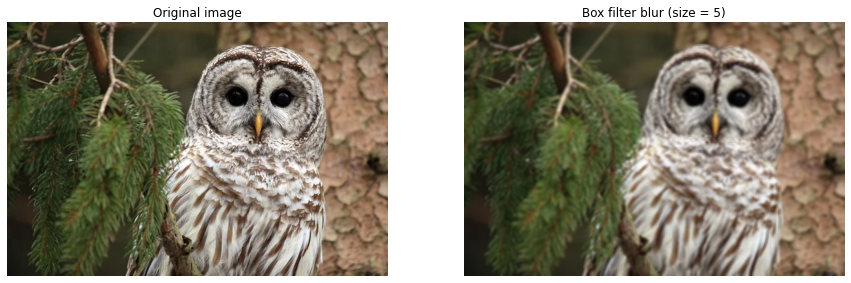

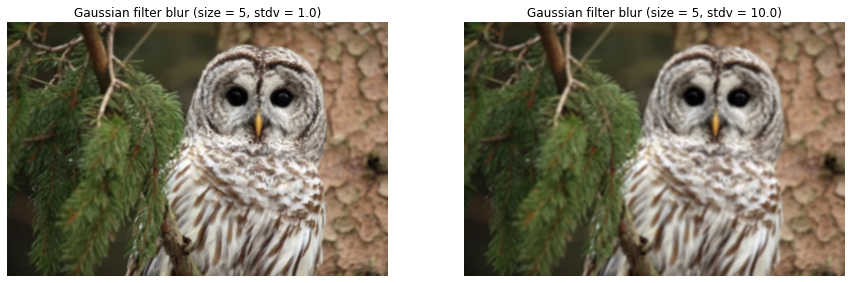

In [4]:
bsize = 5
plot_2_images(img, 
              cv2.blur(img,(bsize, bsize)), 
              "rgb", 
              'Original image',
              'Box filter blur (size = {})'.format(bsize))

stdv1 = 1.
stdv2 = 10.
plot_2_images(cv2.GaussianBlur(img,(bsize, bsize), stdv1), 
              cv2.GaussianBlur(img,(bsize, bsize), stdv2), 
              "rgb", 
              'Gaussian filter blur (size = {}, stdv = {})'.format(bsize, stdv1),
              'Gaussian filter blur (size = {}, stdv = {})'.format(bsize, stdv2))

We can see that the images are smoothed, i.e. we are loosing some high frequency details.

### 1.2 Application on a noisy image

Let's consider an image that has "salt and pepper"/speckle noise, to highlight the limitations of above filters. The image is taken from [here](https://github.com/MeteHanC/Python-Median-Filter).

In [5]:
speckle_noisy_img = cv2.imread('data\sp_noise_image_2.png', 0)

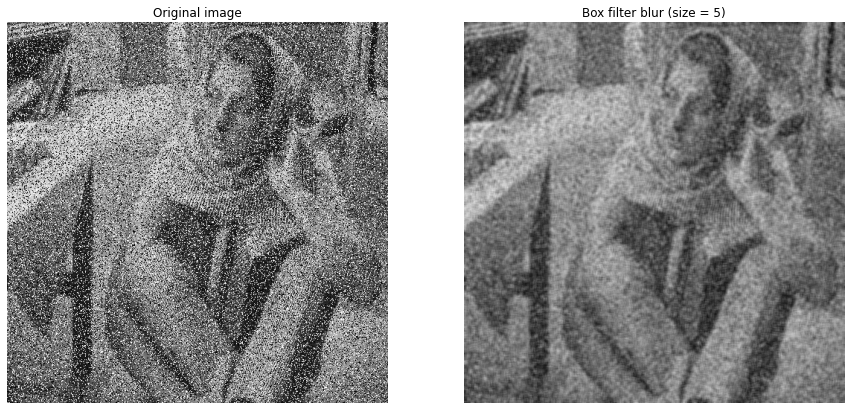

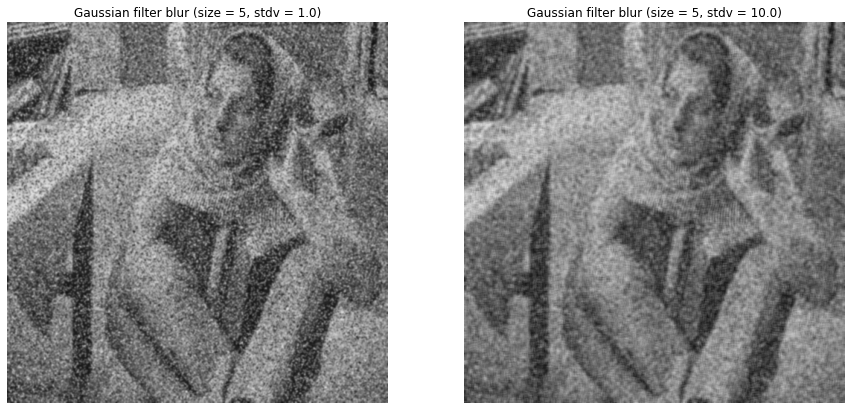

In [6]:
bsize = 5
plot_2_images(speckle_noisy_img, 
              cv2.blur(speckle_noisy_img,(bsize, bsize)), 
              "gray", 
              'Original image',
              'Box filter blur (size = {})'.format(bsize))

stdv1 = 1.
stdv2 = 10.
plot_2_images(cv2.GaussianBlur(speckle_noisy_img,(bsize, bsize), stdv1), 
              cv2.GaussianBlur(speckle_noisy_img,(bsize, bsize), stdv2), 
              "gray", 
              'Gaussian filter blur (size = {}, stdv = {})'.format(bsize, stdv1),
              'Gaussian filter blur (size = {}, stdv = {})'.format(bsize, stdv2))

We can see that these filters are not really effective in removing this kind of noise also called *impulse noise*. We can consider an example of a **non-linear** smoothing filter which gives a better result : the median filter (instead taking an average of a window, we take the median pixel value). See implementation in scripts/admedfilter.py.

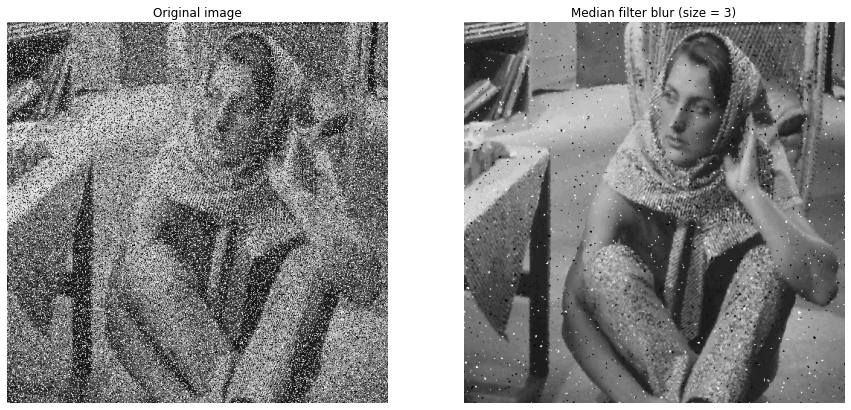

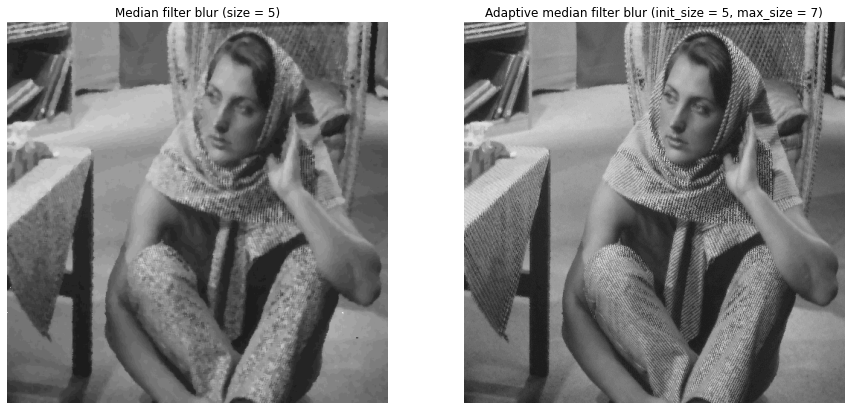

In [7]:
bsize = 3
plot_2_images(speckle_noisy_img, 
              adaptive_median_filter(speckle_noisy_img, w_max = bsize, w_0 = bsize), 
              "gray", 
              'Original image',
              'Median filter blur (size = {})'.format(bsize))

bsize = 5
bsize_0 = 5
bsize_max = 7
plot_2_images(adaptive_median_filter(speckle_noisy_img, w_max = bsize, w_0 = bsize), 
              adaptive_median_filter(speckle_noisy_img, w_max = bsize_max, w_0 = bsize_0), 
              "gray", 
              'Median filter blur (size = {})'.format(bsize),
              'Adaptive median filter blur (init_size = {}, max_size = {})'.format(bsize_0, bsize_max))

The noise removal is better here, even if we observe some artefacts on the borders (which can be handled by padding the original image in a certain way) and a great loss of detail.

## 2. Sharpening / Edge enhancement

Sharpening is the process of enhancing line structures or other details in the original image ([source](http://eeweb.poly.edu/~yao/EE3414/image_filtering.pdf)): this is done by adding a scaled version of the line structures and edges of the original image to the original image. This "scaled version of the line structures and edges of the original image" can be obtained in different ways :

* (2.1) By applying a low pass filter on the image, and subtracting the result from it (original image - its blurred version) which will leave us with high frequency information.
* (2.2) By applying a high pass filter on the image, which is a weighted average but with negative elements e.g. $\begin{bmatrix}
-1 & -1 & -1\\
-1 & 8 & -1\\
-1 & -1 & -1
\end{bmatrix}$. We can see this as the difference between the current pixel and the weighted average of its neighbors.

### 2.1 Unsharp masking

<code>sharpened_image = original_image + gamma * (original_image - blurred_image) </code>
* If gamma = 1., this is called **unsharp masking**, the difference between the original and the blurred creates a mask that we apply on the original image.
* If gamma > 1., this is called **high-boost filtering** since we will give more weight to the high frequency information in the mask.

Of course gamma can be below one which will still produce the effect although more attenuated. One thing to keep in mind is that if we apply this formula directly, we may end up with pixel values outside of our usual range [0, 255] which will lead to saturation problems, some weird color patches will appear. One way to handle this is to use saturation thresholding which is applied as last step in the <code>cv2.addWeighted</code> function.

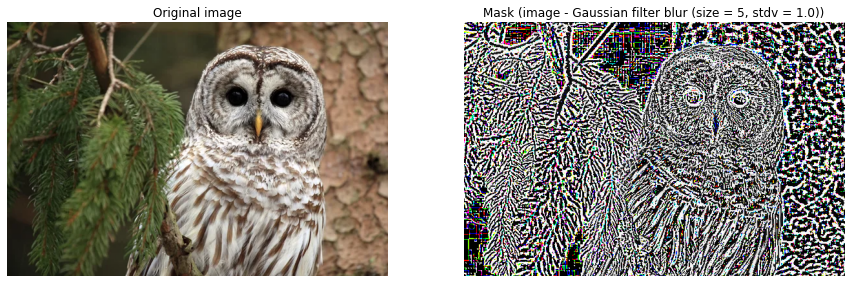

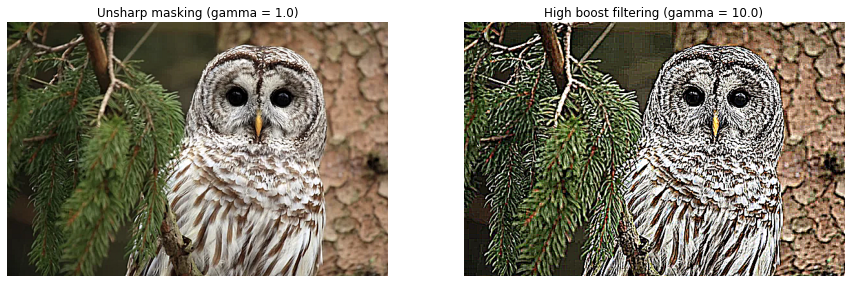

In [8]:
bsize = 5
stdv = 5.
blurred_img = cv2.GaussianBlur(img,(bsize, bsize), stdv)
plot_2_images(img, 
              img - blurred_img, 
              "rgb", 
              'Original image',
              'Mask (image - Gaussian filter blur (size = {}, stdv = {}))'.format(bsize, stdv1))

gamma1 = 1.
gamma2 = 10.
unsharp_masked_img = cv2.addWeighted(img, 1 + gamma1, blurred_img, - gamma1, 0, None)
highboost_filtered_img = cv2.addWeighted(img, 1 + gamma2, blurred_img, - gamma2, 0, None)
plot_2_images(unsharp_masked_img, 
              highboost_filtered_img, 
              "rgb", 
              'Unsharp masking (gamma = {})'.format(gamma1),
              'High boost filtering (gamma = {})'.format(gamma2))

### 2.2 High pass filters

Let's consider these two filters here : $\begin{bmatrix}
-1 & -1 & -1\\
-1 & 8 & -1\\
-1 & -1 & -1
\end{bmatrix}$ and $\begin{bmatrix}
0 & -1 & 0\\
-1 & 4 & -1\\
0 & -1 & 0\end{bmatrix}$. 

The sharpened image follows the same idea as above : <code>sharpened_image = original_image + gamma * high_pass_filtered_image </code>

TODO do we need to do this here ?

An important thing to notice here, as explained [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_gradients/py_gradients.html), is that once we use filters with negative values the result of the convolution can contain negative values. If we stick to working with <code>np.uint8</code> datatype, these values will just be put to zero and we will miss out the information. Thus, we need to use some higher forms of datatype, e.g. <code>np.float64</code>, and then take the absolute value of the matrix to be able to convert it back to <code>np.uint8</code> without losing edge information.

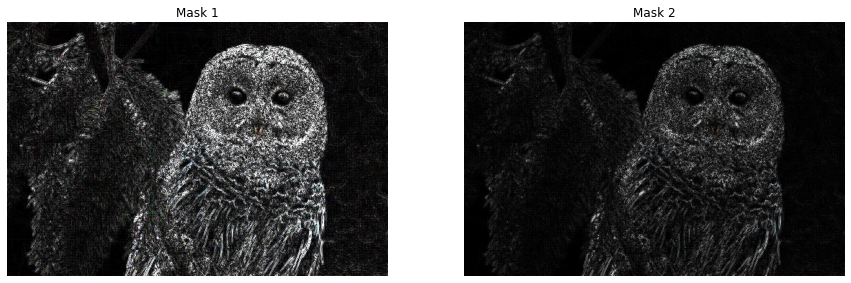

In [9]:
sharpening_filter1 = np.array([[-1, -1, -1],
                              [-1, 8, -1],
                              [-1, -1, -1]])
mask1 = cv2.filter2D(img, cv2.CV_64F, sharpening_filter1)
mask1 = cv2.convertScaleAbs(mask1)

sharpening_filter2 = np.array([[0, -1, 0],
                              [-1, 4, -1],
                              [0, -1, 0]])
mask2 = cv2.filter2D(img, cv2.CV_64F, sharpening_filter2)
mask2 = cv2.convertScaleAbs(mask2)

plot_2_images(mask1, 
              mask2, 
              "rgb", 
              'Mask 1',
              'Mask 2')

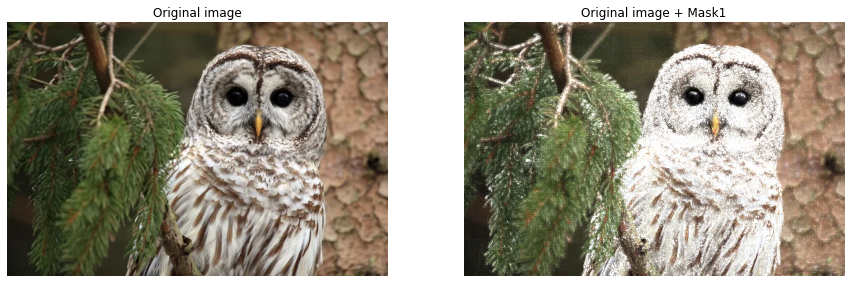

In [10]:
gamma = 1.
plot_2_images(img, 
              cv2.addWeighted(img, 1, mask1, gamma, 0, None), 
              "rgb", 
              'Original image',
              'Original image + Mask1')